# Imports

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2
from sklearn.utils import as_float_array, check_X_y, safe_sqr, safe_mask
from scipy import special
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Read Data

In [2]:
data = pd.read_csv("titanic_cleaned.csv")
print(data.shape)

(825, 1625)


# Train A Model on All the features

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    data.loc[:, data.columns != 'Survived'], data["Survived"], test_size=0.20, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(660, 1624) (165, 1624) (660,) (165,)


In [4]:
clf = MLPClassifier(solver='lbfgs', alpha=0.1,
                                            hidden_layer_sizes=(5,2),
                                            max_iter=90000,activation='tanh',random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

0.8545454545454545
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        98
           1       0.84      0.79      0.82        67

    accuracy                           0.85       165
   macro avg       0.85      0.84      0.85       165
weighted avg       0.85      0.85      0.85       165

0.8445019798964362


# Feature Engineering

### Remove quasi-constant (very small variance) and zero variance

In [5]:
data.drop(data.loc[:, data.var() < 0.01], axis = 1, inplace = True)

### Remove duplicate features

In [6]:
data = data.T.drop_duplicates(keep='first').T

### Remove very strongly correlated features

In [7]:
correlation_matrix = data.corr().abs()
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
data.drop(data[to_drop], axis = 1, inplace = True)

### Feature selection using correlation

In [8]:
operations = json.load(open('titanic_rules.json'))

In [9]:
def f_oneway(*args):
    n_classes = len(args)
    args = [as_float_array(a) for a in args]
    n_samples_per_class = np.array([a.shape[0] for a in args])
    n_samples = np.sum(n_samples_per_class)
    ss_alldata = sum(safe_sqr(a).sum(axis=0) for a in args)
    sums_args = [np.asarray(a.sum(axis=0)) for a in args]
    square_of_sums_alldata = sum(sums_args) ** 2
    square_of_sums_args = [s ** 2 for s in sums_args]
    sstot = ss_alldata - square_of_sums_alldata / float(n_samples)
    ssbn = 0.
    for k, _ in enumerate(args):
        ssbn += square_of_sums_args[k] / n_samples_per_class[k]
    ssbn -= square_of_sums_alldata / float(n_samples)
    sswn = sstot - ssbn
    dfbn = n_classes - 1
    dfwn = n_samples - n_classes
    msb = ssbn / float(dfbn)
    msw = sswn / float(dfwn)
    f = msb / (msw + 1e-15)
    # flatten matrix to vector in sparse case
    f = np.asarray(f).ravel()
    prob = special.fdtrc(dfbn, dfwn, f)
    return f, prob


def f_classif(X, y):
    X, y = check_X_y(X, y, accept_sparse=['csr', 'csc', 'coo'])
    args = [X[safe_mask(X, y == k)] for k in np.unique(y)]
    return f_oneway(*args)

In [10]:
# feature selection using correlation
target_column = 'Survived'
problem_type = 'Classification'
target = data[target_column]
to_drop = []
processed_features = [target_column]
for column in operations:
    if any(data.columns == column['column_name']):
        processed_features.append(column['column_name'])
        if column['is_numeric']:
            if problem_type == 'Classification':
                #ANOVA
                F, P = f_classif(data[[column['column_name'],target_column]], target)
                if P[0] > 0.05:
                    to_drop.append(column['column_name'])
            else:
                #Pearson
                corr = data[column['column_name']].corr(target, method='pearson')
                if corr < 0.05:
                    to_drop.append(column['column_name'])
        else:
            if problem_type == 'Classification':
                #Chi-Squared
                F, P = chi2(data[[column['column_name'],target_column]], target)
                if P[0] > 0.05:
                    to_drop.append(column['column_name'])
            else:
                #ANOVA
                F, P = f_classif(data[[target_column,column['column_name']]], data[column['column_name']])
                if P[0] > 0.05:
                    to_drop.append(column['column_name'])
data_copy = data.copy()
data_copy.drop(processed_features, axis = 1, inplace = True)
for column in data_copy.columns:
    if problem_type == 'Classification':
        #Chi-Squared
        F, P = chi2(data[[column,target_column]], target)
        if P[0] > 0.05:
            to_drop.append(column)
    else:
        #ANOVA
        F, P = f_classif(data[[target_column,column]], data[column])
data.drop(to_drop, axis = 1, inplace = True)
data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Cabin_D,Embarked_C,Embarked_S
0,0.0,3.0,-0.590510,1.0,0.0,-0.626020,0.0,1.0,0.0,1.0
1,1.0,1.0,0.658215,1.0,0.0,1.524562,1.0,0.0,1.0,0.0
2,1.0,3.0,-0.278329,0.0,0.0,-0.603350,1.0,1.0,0.0,1.0
3,1.0,1.0,0.424079,1.0,0.0,0.913869,1.0,0.0,0.0,1.0
4,0.0,3.0,0.424079,0.0,0.0,-0.599151,0.0,1.0,0.0,1.0


### PCA

#### PCA functions

In [11]:
def featureNormalize(X):
    mu = np.asarray(X).mean(axis=0)
    Y = np.asarray(X - mu)
    sigma = pow(np.var(Y, axis=0), 0.5)
    normalized_X = Y / sigma

    return normalized_X

def pca(X):
    cov = np.cov(X, rowvar=False)
    u, s, _ = np.linalg.svd(cov)
    return u

def projectData(X, U):
    Z = np.dot(np.asmatrix(X), np.asmatrix(U[:, :1]))
    return Z

#### Get strongly correlated pairs

In [13]:
corr_matrix = data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
strongly_correlated = []
for column in upper.columns:
    if column == target_column:
        continue
    for i, v in enumerate(upper[column]):
        if upper[column][i] > 0.75 and upper.iloc[i].name != target_column:
            first_numeric = False
            second_numeric = False
            for object in operations:
                if object['column_name'] == column and object['is_numeric']:
                    first_numeric = True
                elif object['column_name'] == upper.iloc[i].name and object['is_numeric']:
                    second_numeric = True
            if first_numeric and second_numeric:    
                strongly_correlated.append([column, upper.iloc[i].name])
strongly_correlated

[]

#### Apply PCA on strongly correlated pairs

In [14]:
for X, Y in strongly_correlated:
    if X not in data.columns or Y not in data.columns:
        continue
    new_name = X + '_' + Y
    pca_input = data[[X,Y]]
    pca_input = featureNormalize(pca_input)
    U = pca(pca_input)
    Z = projectData(pca_input, U)
    Z = pd.DataFrame(Z)
    data.drop([X,Y], axis = 1, inplace = True)
    data[new_name] = Z
data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Cabin_D,Embarked_C,Embarked_S
0,0.0,3.0,-0.590510,1.0,0.0,-0.626020,0.0,1.0,0.0,1.0
1,1.0,1.0,0.658215,1.0,0.0,1.524562,1.0,0.0,1.0,0.0
2,1.0,3.0,-0.278329,0.0,0.0,-0.603350,1.0,1.0,0.0,1.0
3,1.0,1.0,0.424079,1.0,0.0,0.913869,1.0,0.0,0.0,1.0
4,0.0,3.0,0.424079,0.0,0.0,-0.599151,0.0,1.0,0.0,1.0


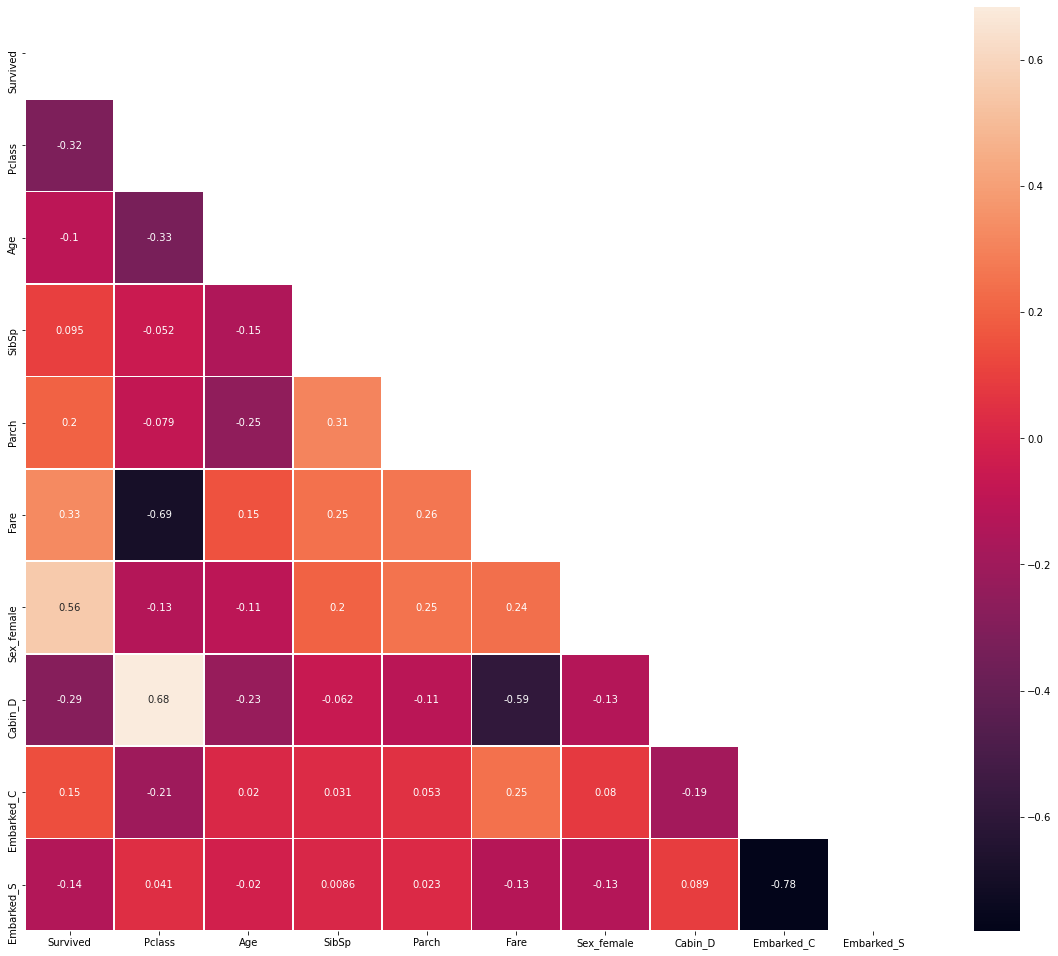

In [15]:
plt.figure(figsize=(20, 17))
matrix = np.triu(data.corr())
sns.heatmap(data.corr(), annot=True,linewidth=.8, mask=matrix, cmap="rocket");

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    data.loc[:, data.columns != 'Survived'], data["Survived"], test_size=0.20, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(660, 9) (165, 9) (660,) (165,)


In [17]:
clf = MLPClassifier(solver='lbfgs', alpha=0.1,
                                            hidden_layer_sizes=(5,2),
                                            max_iter=90000,activation='tanh',random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

0.793939393939394
              precision    recall  f1-score   support

         0.0       0.79      0.89      0.84        98
         1.0       0.80      0.66      0.72        67

    accuracy                           0.79       165
   macro avg       0.80      0.77      0.78       165
weighted avg       0.79      0.79      0.79       165

0.7722357599756321
